# Simple deep multi-layer perceptron Sentinel 2 for the classification of the urban and agriculture areas

This notebook walks you through a simple example of using Earth Engine and Keras.

Specifically, we will train a neural network to recognize land, water, urbar, and cropland pixels in a Sentinel 2 scene ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2)). 
For this simple example we will use the output of the USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL)) as training data.

## Configure the Environment

We begin by importing a number of useful libraries

In [1]:
import ee
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image
from functools import reduce
import h5py

Initialize the Earth Engine client.

In [2]:
ee.Initialize()

**Functions**

In [3]:
def display_image(image, region, Vizz = None):
    """
    Displays images in notebook
    """ 
    ## Visualization
    if Vizz:
        image = image.visualize(**Vizz)
        
    visual = Image(url=image.getThumbUrl({
                'region':region
                }))
    
    display(visual)

In [4]:
def CloudMaskS2(image):
    """
    European Space Agency (ESA) clouds from 'QA60', i.e. Quality Assessment band at 60m
    parsed by Nick Clinton
    """
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = int(2**10)
    cirrusBitMask = int(2**11)

    # Both flags set to zero indicates clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
            qa.bitwiseAnd(cirrusBitMask).eq(0))

    return image.updateMask(mask).divide(10000)

In [5]:
def CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom):
    ## Define your collection
    collection = ee.ImageCollection(Collection_id)

    ## Filter 
    collection = collection.filterBounds(geom).filterDate(startDate,stopDate)\
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))\
            .map(CloudMaskS2)

    ## Composite
    composite = collection.median()
    
    return composite

## Sentinel 2  
### Sentinel-2 MSI: MultiSpectral Instrument, Level-1C ([gee](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2))
**Dataset Availability**: 2015-06-23T00:00:00 - Present

**Wavebands**

|Band 	|Use 		|Wavelength (nm) |Resolution (m)|
|-------|-----------|----------------|--------------|
|B1 	|Aerosols 	|443 	|60|
|B2 	|Blue 		|490 	|10|
|B3 	|Green 		|560 	|10|
|B4 	|Red 		|665 	|10|
|B6 	|Red Edge 2 |740 	|20|
|B8 	|NIR        |835 	|10|
|B8a 	|Red Edge 4 |865 	|20|
|B9 	|Water vapor|940 	|60|
|B10 	|Cirrus 	|1375 	|60|
|B11 	|SWIR 1 	|1610 	|20|
|B12 	|SWIR 2 	|2190 	|20|
|QA60   |ESA Cloud  | n/a   |60|

In [6]:
# GEE Image Collection ID
Collection_id = 'COPERNICUS/S2'
# Start and stop of time series
startDate = ee.Date('2016-01-01')
stopDate  = ee.Date('2016-12-31')
# Scale in meters
scale = 10

**Cloud Free Composite**

RGB

In [7]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(-112.4336, 43.1682).buffer(20000)
#geom = ee.Geometry.Point(-119.5404, 36.2631).buffer(20000)
region = geom.bounds().getInfo()['coordinates']
# Visualization parameters
vis = {'min':0,'max':0.3, 'bands':['B4','B3','B2']}
# Cloud Free Composite
image = CloudFreeCompositeS2(Collection_id, startDate, stopDate, geom)
# Display Composite
display_image(image, region, Vizz = vis)

NIR

In [8]:
# Visualization parameters
vis = {'min':0,'max':0.5, 'gamma':1.5, 'bands':['B8']}
# Display Composite
display_image(image, region, Vizz = vis)

NDVI = (RED-NIR)/(RED+NIR)

In [9]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd', 'palette': palette}
# Calculate NDVI
image_ndvi = image.normalizedDifference(['B8','B4'])
# Display NDVI
display_image(image_ndvi, region, Vizz = vis)

NDWI = (GREEN-NIR)/(GREEN+NIR)

In [10]:
# Visualization parameters
palette = ['blue', 'white', 'green']
vis = {'min': -0.8, 'max': 0.8, 'bands':'nd'}
# Calculate NDWI
image_ndwi = image.normalizedDifference(['B8','B3'])
# Display NDWI
display_image(image_ndwi, region, Vizz = vis)

## Cropland Data Layers
### USDA NASS Cropland Data Layers ([gee](https://developers.google.com/earth-engine/datasets/catalog/USDA_NASS_CDL))

**Dataset Availability**: January 1997 - Present

**Resolution**
30 meters

**Bands**

|Name 	    |Min|Max |Description 	|
|-----------|---|----|--------------|
|cropland 	|1 	|254 |Main crop-specific land cover classification.|
|cultivated |1 	|2   |Classification layer for identifying cultivated and non-cultivated land cover. Available from 2013 to 2017.|
|confidence |0 	|100 |Per-pixel predicted confidence of the given classification, with 0 being the least confident and 100 the most confident.|

In [11]:
# GEE Image Collection ID
Collection_id = 'USDA/NASS/CDL'

Ground truth land cover classification

In [12]:
dataset = ee.ImageCollection(Collection_id)\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)

# First image
image = ee.Image(dataset.first())

# Choose the scale
image =  image.reproject(crs='EPSG:4326', scale=scale)

In [13]:
vis = {'min':1,'max':254, 'bands':'cropland'}
display_image(image, region, Vizz = vis)

## Download datasets
We download and stack datasets from two different Areas of Interest (AOIs)

In [14]:
# Central position of (AOIs)
points = [[-120.7224, 37.3872], [-112.6799, 42.9816]]

In [24]:
from ee_datasets import ee_datasets

for n, point in enumerate(points):
    sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
    cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
    dataset_x = sentinel.read_datasets()
    dataset_y = cropland.read_datasets()
    if n == 0:
        data_x = dataset_x
        data_y = dataset_y
    else:
        szy1, szx1 = data_x.shape[:2]
        szy2, szx2 = dataset_x.shape[:2]
        if szy1 != szy2 or szx1 != szx2:
            szy = min(szy1, szy2)
            szx = min(szx1, szx2)
            
            data_x = np.stack((data_x[:szy,:szx,:], dataset_x[:szy,:szx,:]), axis=0)
            data_y = np.stack((data_y[:szy,:szx,:], dataset_y[:szy,:szx,:]), axis=0)
        else:
            data_x = np.stack((data_x, dataset_x), axis=0)
            data_y = np.stack((data_y, dataset_y), axis=0)

url:  https://earthengine.googleapis.com/api/download?docid=2c7773bf81b2c7b3dab57145b790adee&token=6e17902ff9a79b3f38b15572efef841d
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=cd59074f76406f6d52af4b37b3d2fb84&token=2e108a148c4910be10790fe4d7b32ef8
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=e681d88e9ec6e4a82fcee06871a44648&token=1709d8d3a2252a356a8a0d28892f285e
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=b112c9e1c84fa61dbab5d13eb0ceee37&token=ea7570bde82337a930a298553b72d592
Download complete!


**Display channels**

We display the input and output datasets

In [25]:
def display_channels(data, nChannels, titles = False):
    if nChannels == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(data[:,:,0])
        if titles:
            plt.title(titles[0])
    else:
        fig, axs = plt.subplots(nrows=1, ncols=nChannels, figsize=(5*nChannels,5))
        for i in range(nChannels):
            ax = axs[i]
            ax.imshow(data[:,:,i])
            if titles:
                ax.set_title(titles[i])

Sentinel 2 composite for the for the fist AOI

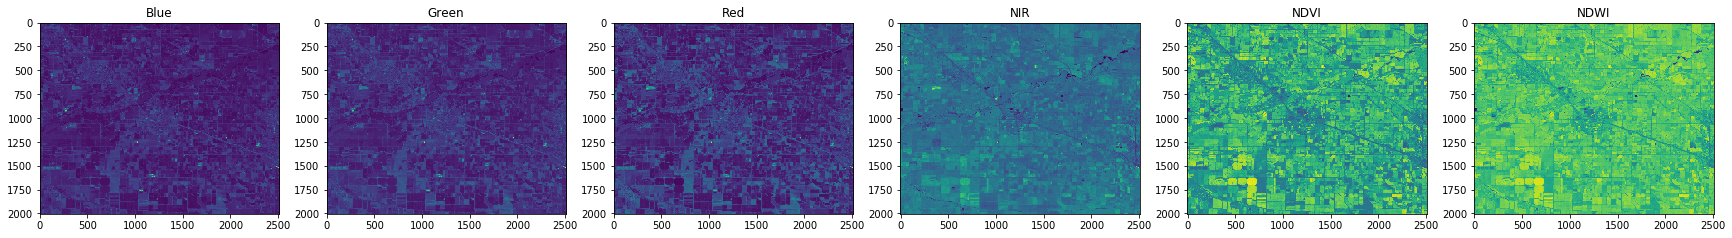

In [26]:
display_channels(data_x[0,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification for the for the fist AOI

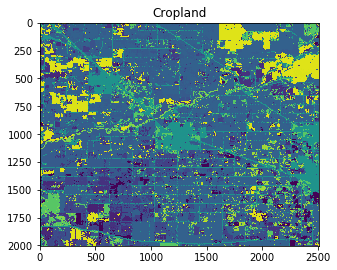

In [27]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Cropland'])

Sentinel 2 composite for the for the second AOI

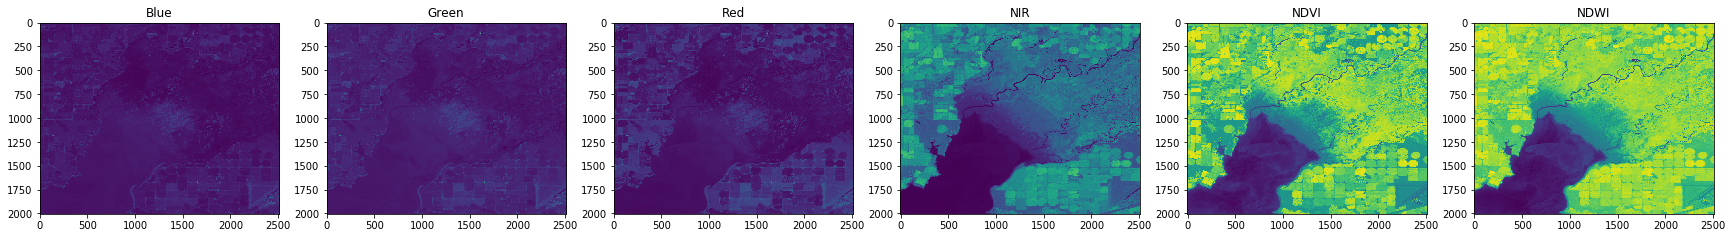

In [28]:
display_channels(data_x[1,:,:,:], data_x.shape[3], titles=['Blue', 'Green', 'Red', 'NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification for the for the second AOI

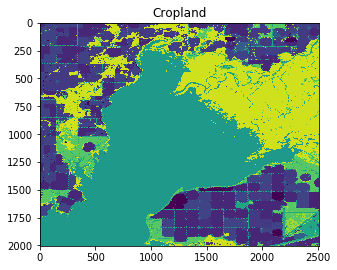

In [29]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Cropland'])

## Preprocess class labels

Each class in encoded as a value in the range between 0 to 254. For training a Neural Network in Keras we have to convert the 1-dimensional class arrays to N classes-dimensional matrices. To simplify the problem here we regroup all the classes into 4 categories, namely, land, water, urban, and cropland areas.

In [30]:
# Area of Interest (AoI)
geom = ee.Geometry.Point(points[0]).buffer(10000)
# Start and stop of time series
startDate = ee.Date('2016')
stopDate  = ee.Date('2017')
# Read the ImageCollection
dataset = ee.ImageCollection('USDA/NASS/CDL')\
    .filterBounds(geom)\
    .filterDate(startDate,stopDate)
# Get the cropland class values and names
cropland_info = pd.DataFrame({'cropland_class_values':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_values'),
                              'cropland_class_palette':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_palette'),
                              'cropland_class_names':dataset.getInfo().get('features')[0].get('properties').get('cropland_class_names')
                             })
cropland_info.head()

,cropland_class_values,cropland_class_palette,cropland_class_names
0,0.0,000000,Background
1,1.0,ffd300,Corn
2,2.0,ff2626,Cotton
3,3.0,00a8e5,Rice
4,4.0,ff9e0c,Sorghum


The number of unique classes in this are is equal to:

In [31]:
len(np.unique(data_y[:,:,:,0]))

65

and the number of pixels by class

In [32]:
value, count = np.unique(data_y[0,:,:,0], return_counts=True)
df = pd.DataFrame({'cropland_class_values': value, 'cropland_class_counts': count})
df.sort_values(by='cropland_class_counts', ascending=False, inplace=True)
df = pd.merge(df, cropland_info, how='left', on=['cropland_class_values'])
df.head()

,cropland_class_values,cropland_class_counts,cropland_class_palette,cropland_class_names
0,75.0,1780077,00a582,Almonds
1,69.0,729633,704489,Grapes
2,226.0,310696,ffd300,Dbl Crop Oats/Corn
3,121.0,270645,9b9b9b,Developed/Open Space
4,176.0,269589,e8ffbf,Grassland/Pasture


Create new classes:
- Land
- Water
- Urban
- Croplands

In [33]:
def replace_values(array, class_labels, new_label):
    array_new = np.copy(array)
    for i in range(len(class_labels)):
        array_new[np.where(array == class_labels[i])] = new_label
        
    return array_new

In [34]:
# New classes
land = ['Shrubland', 'Barren', 'Grassland/Pasture', 'Deciduous Forest', 'Evergreen Forest', 'Mixed Forest', 'Wetlands', 'Woody Wetlands', 'Herbaceous Wetlands']
water = ['Water', 'Open Water', 'Aquaculture']
urban = ['Developed', 'Developed/Open Space', 'Developed/High Intensity', 'Developed/Low Intensity', 'Developed/Med Intensity']

class_labels_0 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(land)]['cropland_class_values'])
class_labels_1 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(water)]['cropland_class_values'])
class_labels_2 = np.array(cropland_info[cropland_info['cropland_class_names'].isin(urban)]['cropland_class_values'])
class_labels_3 = np.array(cropland_info[(~cropland_info['cropland_class_names'].isin(land)) & 
                                        (~cropland_info['cropland_class_names'].isin(water)) & 
                                        (~cropland_info['cropland_class_names'].isin(urban))]['cropland_class_values'])

# We replace the class labels
new_data_y = np.copy(data_y[:,:,:,0])
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, 4)
data_y = new_data_y

Using TensorFlow backend.


New classification for the for the first AOI

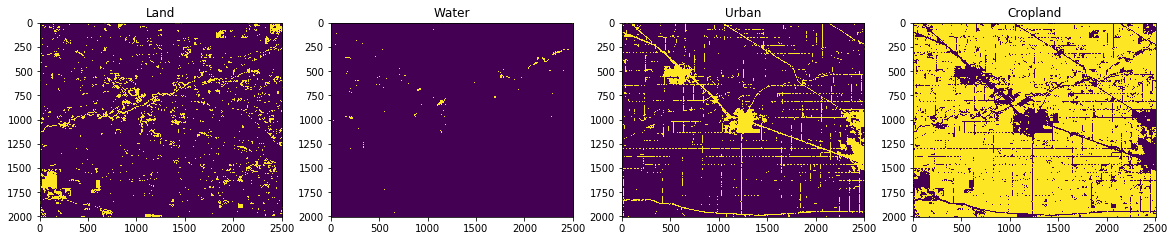

In [35]:
display_channels(data_y[0,:,:,:], data_y.shape[3], titles=['Land', 'Water', 'Urban', 'Cropland'])

New classification for the for the second AOI

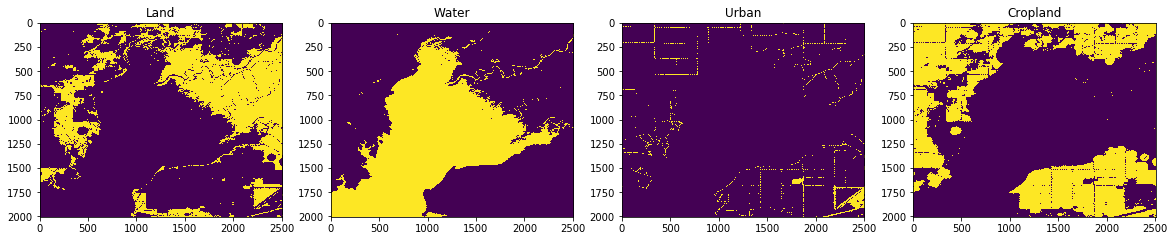

In [36]:
display_channels(data_y[1,:,:,:], data_y.shape[3], titles=['Land', 'Water', 'Urban', 'Cropland'])

**Select input channels**

We will only use NIR, NDVI, and NDWI as an input channels

In [37]:
data_x = data_x[:,:,:,3:]

## Preprocess datasets for training a Fully Connected Network (FCN)

**Normalize data**

In [39]:
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,:,i].max()
        mn = data[:,:,:,i].min()
        
        data[:,:,:,i] = (data[:,:,:,i]-mn)/(mx-mn)
    return data

In [40]:
data_x = normalize_data(data_x)

**Resize the images**

Current shape

In [41]:
data_x.shape

(2, 2004, 2506, 3)

In [42]:
data_y.shape

(2, 2004, 2506, 4)

In [43]:
def reshape_data(data):
    size = data.shape
    new_size = []
    new_size.append(reduce(lambda x, y: x*y, size[:-1]))
    new_size.append(size[-1])
    new_size = tuple(new_size)
    return size, new_size

In [44]:
size_x, new_size_x = reshape_data(data_x)
size_y, new_size_y = reshape_data(data_y)

data_x_new = data_x.reshape(new_size_x)
data_y_new = data_y.reshape(new_size_y)

New shape

In [45]:
data_x_new.shape

(10044048, 3)

In [46]:
data_y_new.shape

(10044048, 4)

**Randomize the datasets**

In [47]:
def randomize_datasets(data_x, data_y):
    t=data_x.shape[0]
    arr_t = np.arange(t)
    np.random.shuffle(arr_t)
    data_x = data_x[arr_t,:]
    data_y = data_y[arr_t,:]
    
    return data_x, data_y

In [48]:
x_randm, y_randm = randomize_datasets(data_x_new, data_y_new)

**Training and validation sets**

In [49]:
def train_validation_split(x, y, val_size=20):
    t=x.shape[0]
    size = int(t*((100-val_size)/100))
    
    xt = x[:size,:]
    xv = x[size:,:]
    yt = y[:size,:]
    yv = y[size:,:]
    
    return xt, xv, yt, yv

In [50]:
x_train, x_validation, y_train, y_validation = train_validation_split(x_randm, y_randm)

## Define the Keras model

Here we define a neural network with two hidden layers with `relu` nonlinearities.

In [51]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 32
num_bands = 3
num_classes = 4
epochs = 1

model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 266,756
Trainable params: 266,756
Non-trainable params: 0
_________________________________________________________________


**Compile the model**

In [52]:
from keras.optimizers import RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

**Train the Neural Network**

In [53]:
from keras.callbacks import Callback, ModelCheckpoint

In [54]:
# To saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath="{0}_weights.hdf5".format('FCN'), verbose=1, save_best_only=True)

In [55]:
model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_validation, y_validation), callbacks=[checkpointer])

Train on 8035238 samples, validate on 2008810 samples
Epoch 1/1
8035238/8035238 [==============================] - 977s 122us/step - loss: 0.6555 - acc: 0.7630 - val_loss: 0.6703 - val_acc: 0.7567

Epoch 00001: val_loss improved from inf to 0.67034, saving model to FCN_weights.hdf5


**Evaluate model**

In [57]:
score = model.evaluate(x_validation, y_validation, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6703353314227659
Test accuracy: 0.7567032223058026


**Read the weights**

In [ ]:
batch_size = 32
num_bands = 3
num_classes = 4
epochs = 1

model = Sequential()
model = Sequential()

model.add(Dense(512, activation = 'relu', input_shape=(num_bands,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = 'softmax'))

model.load_weights("{0}_weights.hdf5".format('FCN'))

## Predict

First we test the FCN in a AOI that is close to one of the training AOI.

In [94]:
# Central position of (AOIs)
point = [-112.4336, 43.1682]

In [101]:
sentinel = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'Sentinel2')
dataset_x = sentinel.read_datasets()
cropland = ee_datasets(point = point, buffer = 10000 , startDate = startDate, stopDate = stopDate, scale = scale, collection = 'CroplandDataLayers')
dataset_y = cropland.read_datasets()

url:  https://earthengine.googleapis.com/api/download?docid=75ba4d40d5d475b68eca9ab3f5b54e84&token=6345fc3bfdf06d82e2a4178f3d756042
Download complete!
url:  https://earthengine.googleapis.com/api/download?docid=b41191e55adc08f76b0d5572c724a477&token=3e89dcb8d49742f6d3c30b9bc81ce1d3
Download complete!


We select the NIR, NDVI, NDWI channels

In [102]:
data_x = dataset_x[:,:,3:]
data_y = dataset_y

Sentinel 2 composite

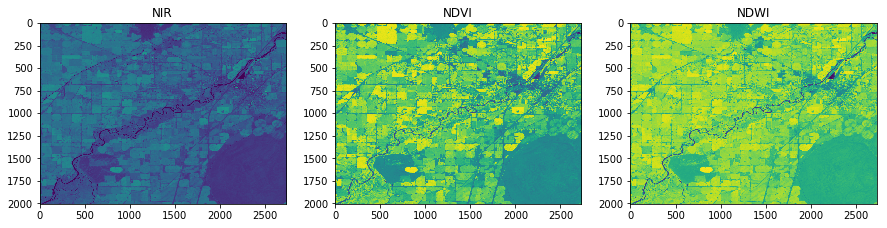

In [103]:
display_channels(data_x, data_x.shape[2], titles=['NIR', 'NDVI', 'NDWI'])

Ground truth land cover classification

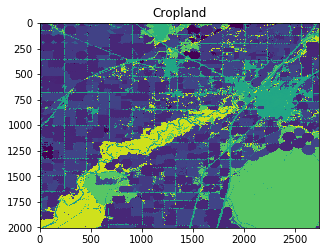

In [104]:
display_channels(data_y, data_y.shape[2], titles=['Cropland'])

**Preprocess class labels**

In [105]:
# We replace the class labels
new_data_y = np.copy(data_y[:,:,0])
new_data_y = replace_values(new_data_y, class_labels_3, 3.)
new_data_y = replace_values(new_data_y, class_labels_2, 2.)
new_data_y = replace_values(new_data_y, class_labels_1, 1.)
new_data_y = replace_values(new_data_y, class_labels_0, 0.)

# Convert 1-dimensional class arrays to 4-dimensional class matrices
from keras.utils import np_utils
new_data_y = np_utils.to_categorical(new_data_y, 4)

Output classes

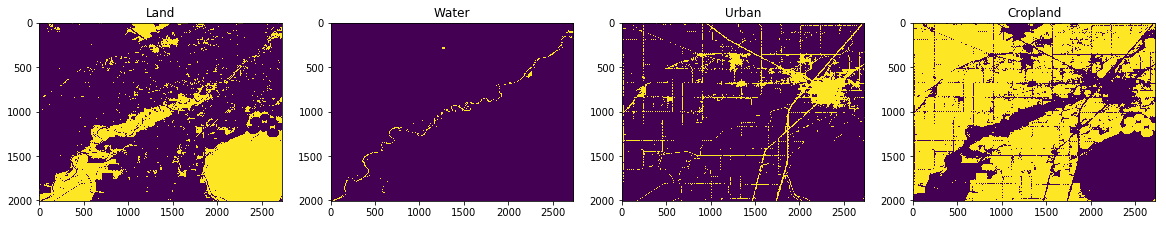

In [106]:
display_channels(new_data_y, new_data_y.shape[2], titles=['Land', 'Water', 'Urban', 'Cropland'])

**Preprocess input dataset**

In [107]:
# Normalize
def normalize_data(data):
    size = data.shape
    for i in range(size[-1]):
        mx = data[:,:,i].max()
        mn = data[:,:,i].min()
        
        data[:,:,i] = (data[:,:,i]-mn)/(mx-mn)
    return data
data_x_norm = normalize_data(data_x)

In [108]:
# Normalize
data_x_norm = normalize_data(data_x)
# Resize
size_x, new_size_x = reshape_data(data_x_norm)

x_input = data_x_norm.reshape(new_size_x)

**Compute the prediction**

In [109]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

**Resize the output**

In [110]:
data_y_output = y_output.reshape((size_x[0], size_x[1],4))

**Display the output**

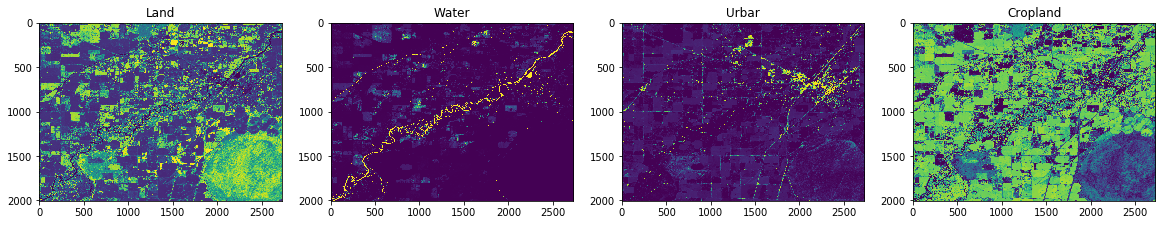

In [111]:
display_channels(data_y_output, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

We binarize the output taking the highest pixel value

In [112]:
# Binarize the output
def max_pixels(x):
    x_new = x*0
    max_val = np.amax(x, axis=2)
    size = x.shape
    for i in range(size[-1]):
        ima = x[:,:,i]*0
        ima[np.where(x[:,:,i] == max_val)] = 1
        x_new[:,:,i]= ima

    return x_new

In [113]:
data_y_output_max = max_pixels(data_y_output)

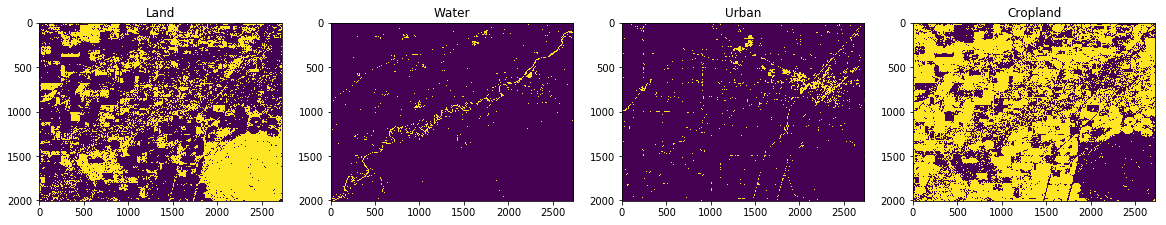

In [114]:
display_channels(data_y_output_max, data_y_output.shape[2], titles=['Land', 'Water', 'Urban', 'Cropland'])

If we compare the ground truth with the prediction we find that the FCN performes quite well for the land, water, and cropland areas but it fails in detecting urban areas.

First we test the FCN in a AOI that is very different from those used for training.

In [ ]:
point = [19.7368, -17.9489]

In [ ]:
from Landsat_dataset import landsat_datasets
landsat = landsat_datasets(point = point, buffer = 12000 , startDate = '2014', stopDate = '2017', scale = 30)
dataset_x = landsat.read_datasets()

We select the NIR and NDVI channels

In [ ]:
dataset_x = dataset_x[:,:,3:]

Lansat 7 composite

In [ ]:
display_channels(dataset_x, dataset_x.shape[2], titles=['NIR', 'NDVI'])

**Preprocess input dataset**

In [ ]:
# Normalize
dataset_x_norm = normalize_data(dataset_x)
# Resize 
size_x, new_size_x = reshape_data(dataset_x_norm)

x_input = dataset_x_norm.reshape(new_size_x)

**Compute the prediction**

In [ ]:
y_output = model.predict(x_input, batch_size=batch_size, verbose=0)

**Resize the output**

In [ ]:
data_y_output = y_output.reshape((size_x[0], size_x[1],4))

**Display the output**

In [ ]:
display_channels(data_y_output, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])

In [ ]:
data_y_output_max = max_pixels(data_y_output)
display_channels(data_y_output_max, data_y_output.shape[2], titles=['Land', 'Water', 'Urbar', 'Cropland'])